In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
link = '/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet'

In [3]:
df_trafic = pd.read_parquet(link)

In [4]:
df_prediction_taux_occupation = pd.read_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/taux_occupation_predictions.csv')

In [5]:
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_prediction_taux_occupation['heure_arrondie'])

In [6]:
df_trafic['heure_arrondie'] = pd.to_datetime(df_trafic['heure_arrondie'])
cutoff_date = pd.to_datetime('2025-03-08')
df_train = df_trafic[df_trafic['heure_arrondie'] < cutoff_date].copy()
df_train = df_train.sort_values(by=['nom_du_troncon', 'heure_arrondie'])


In [7]:
df_test = pd.merge(
    df_prediction_taux_occupation,
    df_trafic,
    on=['heure_arrondie', 'nom_du_troncon']
)
df_test = df_test.drop(columns='taux_occupation')
df_test.rename(columns = {'taux_occupation_pred' : 'taux_occupation'}, inplace=True)
df_test = df_test.sort_values(by=['nom_du_troncon', 'heure_arrondie'])

In [8]:
# --- ÉTAPE 1 : PRÉPARATION DES DONNÉES ---

# 1a. Sélection des features et de la cible
features = ['taux_occupation', 'weekday', 'is_vacances', 'is_ferie', 
            'has_event_near_troncon', 'troncon_enc', 'temperature_2m', 
            'precipitation', 'visibility', 'wind_speed_10m']
target = 'etat_du_trafic'

# 1b. Encodage de la cible textuelle en numérique
# 'Fluide' -> 0, 'Dense' -> 1, 'Saturé' -> 2, 'Bloqué' -> 3
label_encoder = LabelEncoder()
df_train['target_enc'] = label_encoder.fit_transform(df_train[target])
df_test['target_enc'] = label_encoder.transform(df_test[target]) # Utiliser le même encodeur
N_CLASSES = len(label_encoder.classes_)

# Concaténer les features et la cible encodée pour la création des séquences
data_train_processed = pd.concat([df_train[features], df_train['target_enc']], axis=1)
data_test_processed = pd.concat([df_test[features], df_test['target_enc']], axis=1)

# 1c. Mise à l'échelle (Scaling) des features
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train_processed)
data_test_scaled = scaler.transform(data_test_processed)

# 1d. Création des séquences
def create_classification_sequences(data, n_timesteps, n_classes):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:(i + n_timesteps), :-1]) # Toutes les features, sauf la dernière colonne (cible)
        y_index = int(data[i + n_timesteps, -1]) # La cible est la dernière colonne
        y.append(y_index)
    # One-hot encoding de la cible
    return np.array(X), to_categorical(y, num_classes=n_classes)

N_TIMESTEPS = 4 # 1h d'historique (4 * 15min)
X_train, y_train = create_classification_sequences(data_train_scaled, N_TIMESTEPS, N_CLASSES)
X_test, y_test = create_classification_sequences(data_test_scaled, N_TIMESTEPS, N_CLASSES)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}") # La dernière dimension est le nombre de classes

Shape de X_train: (1377407, 4, 10)
Shape de y_train: (1377407, 4)


In [9]:
# --- ÉTAPE 2 : CONSTRUCTION DU MODÈLE LSTM POUR LA CLASSIFICATION ---
N_FEATURES = X_train.shape[2]

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(N_TIMESTEPS, N_FEATURES)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# MODIFICATION : Couche de sortie avec 4 neurones (1 par classe) et activation softmax
model.add(Dense(units=N_CLASSES, activation='softmax'))

# MODIFICATION : Compilation avec une 'loss' adaptée à la classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,604 (127.36 KB)

 Trainable params: 32,604 (127.36 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# --- ÉTAPE 3 : ENTRAÎNEMENT DU MODÈLE ---
print("\nDébut de l'entraînement...")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


Début de l'entraînement...
Epoch 1/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 181s 5ms/step - accuracy: 0.9943 - loss: 0.0291 - val_accuracy: 0.9939 - val_loss: 0.0276
Epoch 2/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 178s 5ms/step - accuracy: 0.9948 - loss: 0.0197 - val_accuracy: 0.9939 - val_loss: 0.0276
Epoch 3/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 167s 4ms/step - accuracy: 0.9948 - loss: 0.0194 - val_accuracy: 0.9940 - val_loss: 0.0256
Epoch 4/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 163s 4ms/step - accuracy: 0.9948 - loss: 0.0190 - val_accuracy: 0.9939 - val_loss: 0.0244
Epoch 5/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 158s 4ms/step - accuracy: 0.9947 - loss: 0.0194 - val_accuracy: 0.9940 - val_loss: 0.0246
Epoch 6/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step - accuracy: 0.9946 - loss: 0.0195 - val_accuracy: 0.9939 - val_loss: 0.0245
Epoch 7/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 166s 4ms/step - accuracy: 0.9948 - loss: 0.0190 - val_accuracy: 0.9939 - val_loss: 0.0247
Epoch 8/20
38740/38740 ━━━━━━━━━━━


Évaluation sur le jeu de test...
13482/13482 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
--- Rapport de Classification ---
              precision    recall  f1-score   support

      Bloqué       1.00      1.00      1.00    429278
       Dense       0.18      0.02      0.04      2142
      Fluide       0.00      0.00      0.00         0
      Saturé       0.00      0.00      0.00         0

    accuracy                           0.99    431420
   macro avg       0.29      0.26      0.26    431420
weighted avg       0.99      0.99      0.99    431420


--- Matrice de Confusion ---


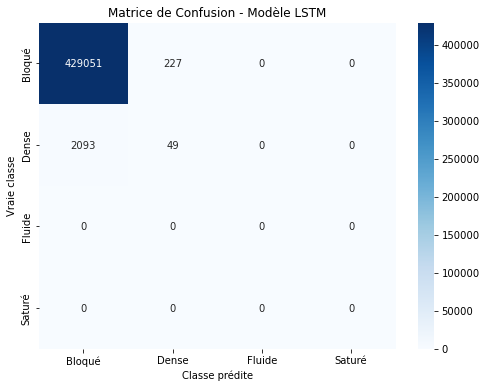

In [12]:

# --- ÉTAPE 4 : PRÉDICTION ET ÉVALUATION ---
print("\nÉvaluation sur le jeu de test...")
# La prédiction donne des probabilités pour chaque classe
predictions_proba = model.predict(X_test)

# Pour obtenir la classe prédite, on prend l'index de la probabilité la plus élevée
y_pred_classes = np.argmax(predictions_proba, axis=1)

# On doit aussi récupérer les vraies classes (non one-hot-encodées) pour la comparaison
y_true_classes = np.argmax(y_test, axis=1)

# Afficher le rapport de classification
target_names = label_encoder.classes_ 

# La liste des index numériques correspondants
# ex: [0, 1, 2, 3]
labels_numeriques = range(N_CLASSES) 

# Afficher le rapport de classification en forçant tous les labels
print("--- Rapport de Classification ---")
# J'ajoute 'zero_division=0' pour éviter un avertissement si une classe n'a aucun vrai échantillon
print(classification_report(y_true_classes, y_pred_classes, 
                            labels=labels_numeriques, 
                            target_names=target_names, 
                            zero_division=0))

# Afficher la matrice de confusion en forçant tous les labels
print("\n--- Matrice de Confusion ---")
# Cela garantit que la matrice cm sera toujours de taille 4x4
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=labels_numeriques)

plt.figure(figsize=(8, 6))
# Le code d'affichage est bon car il utilise déjà target_names
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion - Modèle LSTM')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()